Atnaujintas Giluminio mokymosi modelis

Kas pakeista?

   Naudojami confusion_matrix, seaborn ir pandas

   Naudojama atskirame modelyje (Sequential su sluoksniais: RandomFlip, RandomRotation)

   Papildoma modelio apžvalga ir išveda tikslaus modelio veikimo (accuracy, loss) vertinimą, taip pat jis naudoja papildomus duomenis (kaip accuracy_percent ir loss_rounded)

   Įtraukiamas kerastuner modulis (HyperModel), kuris galėtų būti naudojamas hiperparametrų derinimui

   Treniravimo metu naudojamas validacijos duomenų rinkinys per validation_data=(test_images, test_labels), taip įvertinant modelio veikimą tiek treniravimo, tiek validacijos metu. Pirmame kode  naudoja validation_data per fit funkciją.


Instaliuojame keras tuner biblioteką hiperparamerų optimizavimui

In [ ]:
!pip install keras-tuner


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.1 MB/s eta 0:00:00


Bibliotekų importavimas

---



In [ ]:
# Importuojame reikalingas bibliotekas
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
from kerastuner import HyperModel

<ipython-input-2-15915f74d63b>:9: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import HyperModel


Duomenų užkrovimas

In [ ]:
# CIFAR-10 duomenų užkrovimas
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step


Data Augmentation paruošimas

In [ ]:
# Data Augmentation naudojimas kaip atskiras procesas
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomTranslation(0.1, 0.1),  # Pridėti vertikalią ir horizontalią perkėlimą
    layers.RandomContrast(0.2),  # Kontrasto pakeitimas
])

Užkrautų treniravimo duomenų normalizavimas

In [ ]:

# Normalizuokime duomenis (būtina prieš treniravimą)
train_images = train_images / 255.0
test_images = test_images / 255.0

Modelio kūrimas su konvoliuciniais sluoksniais, Dropout, Data Augmentation.

In [ ]:
# Sukuriame modelį su Dropout ir Data Augmentation
model = models.Sequential([

    # Pirmas konvoliucinis sluoksnis su įvesties forma
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),  # Padidintas Dropout

    # Pritaikome Data Augmentation treniravimo metu
    layers.Lambda(lambda x: data_augmentation(x)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),  # Padidintas Dropout

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),  # Padidintas Dropout

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Dropout sluoksnis
    layers.Dense(10, activation='softmax')  # Softmax aktyvacija paskutiniame sluoksnyje
])

# Modelio apžvalga
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 4, 4, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 160,202 (625.79 KB)

 Trainable params: 160,202 (625.79 KB)

 Non-trainable params: 0 (0.00 B)

Modelio treniravimas su mokymosi greičio tvarkaraščiu.

In [ ]:
# Mokymosi greičio sumažinimas kas epochą (Step Decay)
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True
)

Modelio kompiliavimas, optimizatoriaus parinkimas

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


Modelio treniravimas

In [ ]:
# Modelio treniravimas
history = model.fit(train_images, train_labels, epochs=20, validation_data=(test_images, test_labels))

Epoch 1/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 163s 102ms/step - accuracy: 0.2269 - loss: 2.0178 - val_accuracy: 0.4575 - val_loss: 1.4858
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 199s 100ms/step - accuracy: 0.4030 - loss: 1.6291 - val_accuracy: 0.4961 - val_loss: 1.4015
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 203s 101ms/step - accuracy: 0.4394 - loss: 1.5384 - val_accuracy: 0.5180 - val_loss: 1.3489
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 164s 105ms/step - accuracy: 0.4587 - loss: 1.4843 - val_accuracy: 0.5437 - val_loss: 1.2777
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 194s 100ms/step - accuracy: 0.4732 - loss: 1.4622 - val_accuracy: 0.5705 - val_loss: 1.2190
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 158s 101ms/step - accuracy: 0.4924 - loss: 1.4174 - val_accuracy: 0.5480 - val_loss: 1.2704
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 201s 100ms/step - accuracy: 0.5056 - loss: 1.3879 - val_accuracy: 0.5845 - val_loss: 1.1845
Epoch 8/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 206s 103ms/step - ac

Modelio vertinimas Po mokymo įvertinsime modelio tikslumą su testavimo duomenimis.

In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f'Test accuracy: {test_acc}')


NameError: name 'model' is not defined

Tikslumo ir nuostolių vizualizavimas per epochas.

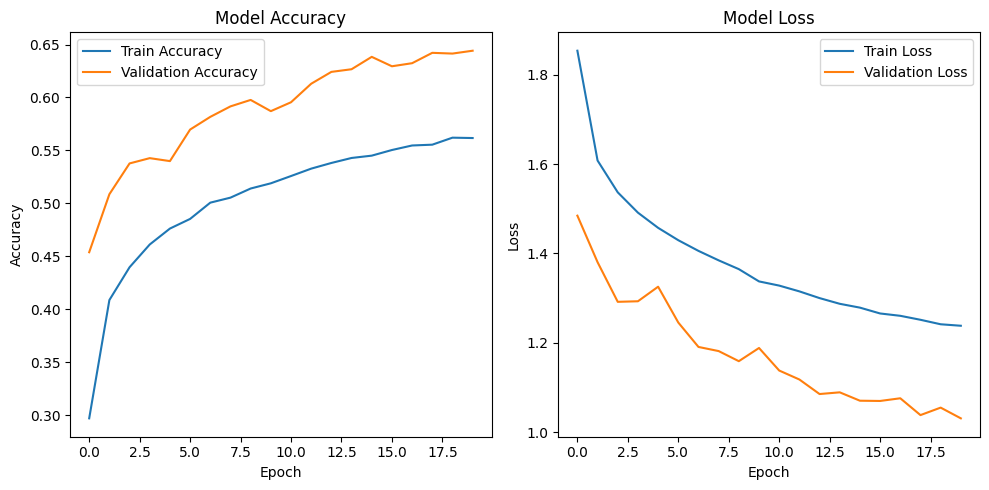

In [ ]:
# Tikslumo ir nuostolių kreivės per epochas
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Confusion Matrix vizualizavimas ir klaidingai klasifikuotų nuotraukų analizė.

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step


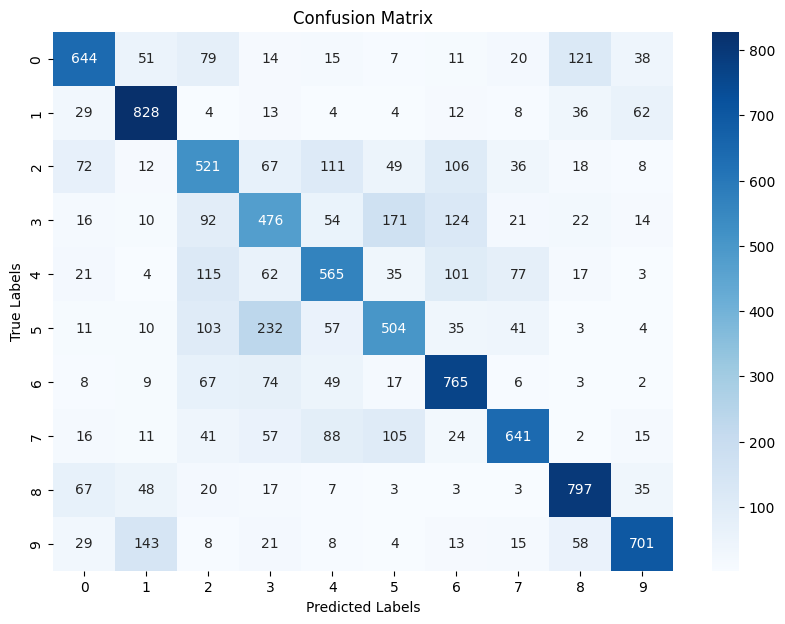

In [ ]:
# Sukuriame confusion matrix ir ją vizualizuojame
y_pred = model.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(test_labels, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

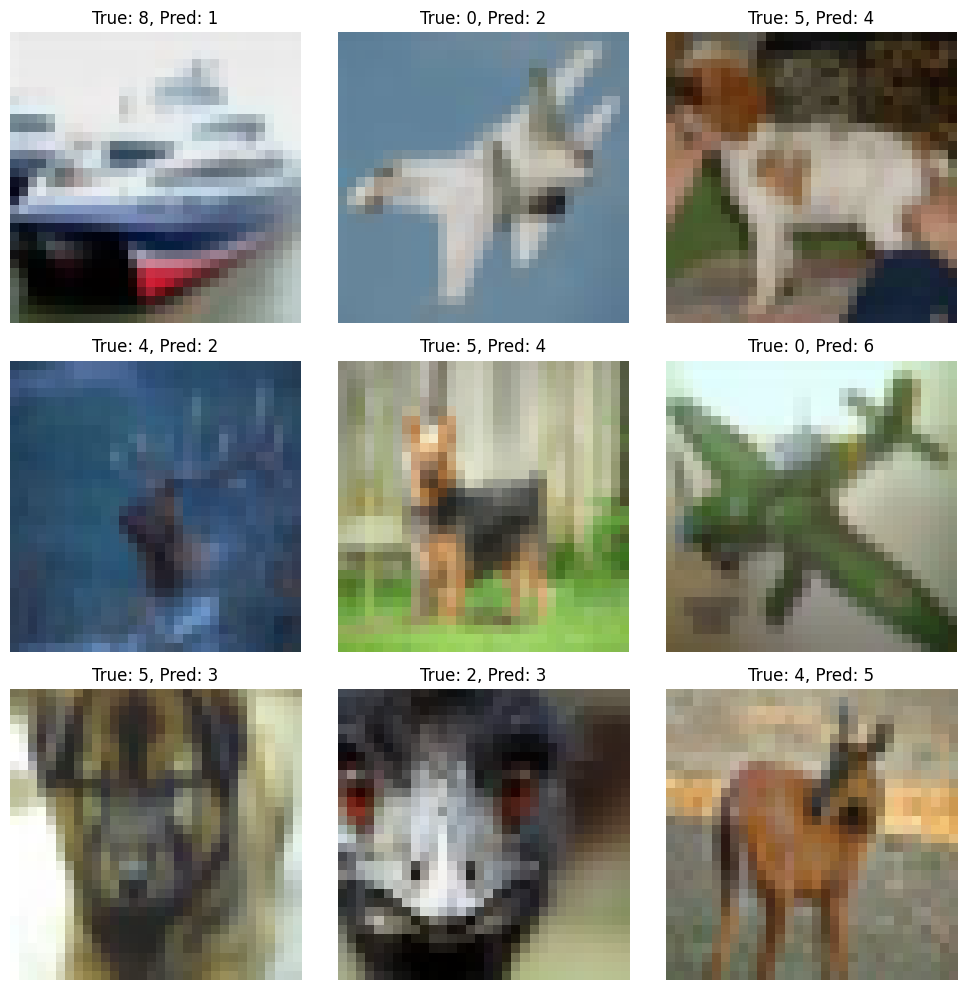

In [ ]:
# Klaidingai klasifikuotos nuotraukos
incorrect_indices = np.where(y_pred_classes != test_labels.flatten())[0]
incorrect_images = test_images[incorrect_indices]
incorrect_labels = test_labels[incorrect_indices]
incorrect_predictions = y_pred_classes[incorrect_indices]

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(incorrect_images[i])
    plt.title(f"True: {incorrect_labels[i][0]}, Pred: {incorrect_predictions[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()